<a href="https://colab.research.google.com/github/LongNguyen1984/GANLearning/blob/main/BloodPressure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import torch
#e = math.exp(1);

def SBPmodel(ptt,Ka, Kb, Kc):
  return Kb + (2/0.031)*torch.log(Kc/ptt) + 2*Ka/(3*(ptt**2))+ 41 
  #return Kb - Ka/(3*(ptt**2))
def model(ptt,Ka,Kb,Kc):
  return Kb + (2/0.031)*torch.log(Kc/ptt) - 1*Ka/(3*(ptt**2))


In [ ]:
model(1,1,2,1)

In [ ]:
def loss_fn(t_p, t_c):
  squared_diffs = (t_p - t_c)**2
  return squared_diffs.mean()


In [ ]:
#t_c =[12.0,	4.50,	3.11,	2.625,	2.40,	2.277,	2.204,	2.156,	2.123,	2.10,	2.082,	2.069,	2.05,	2.05,	2.044,	2.039,	2.034,	2.0308,	2.027,	2.025]
#t_u =[5.0,	1.25,	0.55,	0.312,	0.20,	0.138,	0.102,	0.0781,	0.061,	0.050,	0.041,	0.0347,	0.029,	0.025,	0.022,	0.019,	0.017,	0.015,	0.013,	0.0125]
#t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
#t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_u = [20.296, 14.796, 19.642, 14.992, 18.923, 14.24, 19.862, 19.038, 16.558, 16.737, 17.321, 16.898, 18.404, 19.097, 20.393, 19.019]
t_c = [65.0, 89.0, 72.0, 82.0, 70.0, 97.0, 70.0, 83, 81, 82, 80, 79, 63, 57, 60, 58]
t_s = [104.0, 128.0, 109.0, 128.0, 109.0, 130.0, 101.0, 111, 116, 120, 120, 124, 125, 115, 113, 112, ]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)
t_s = torch.tensor(t_s)

In [ ]:
len(t_u), len(t_c), len(t_s)

(16, 16, 16)

In [ ]:
import torch

Ka = torch.ones(())
Kb = torch.zeros(())
Kc = torch.ones(())

t_p = model(t_u, Ka, Kb, Kc)
t_p

tensor([-194.2217, -173.8310, -192.1086, -174.6800, -189.7027, -171.3600,
        -192.8272, -190.0936, -181.0896, -181.7832, -183.9959, -182.4009,
        -187.9086, -190.2933, -194.5293, -190.0292])

In [ ]:
loss = loss_fn(t_p, t_c)
loss

tensor(67609.0234)

In [ ]:
delta = 0.1
loss_rate_of_change_Ka = \
(loss_fn(model(t_u, Ka + delta, Kb, Kc), t_c) -
loss_fn(model(t_u, Ka - delta, Kb, Kc), t_c)) / (2.0 * delta)

In [ ]:
# In[9]:
learning_rate = 1e-2
Ka = Ka - learning_rate * loss_rate_of_change_Ka

loss_rate_of_change_Kb = \
(loss_fn(model(t_u, Ka, Kb + delta,Kc), t_c) -
loss_fn(model(t_u, Ka, Kb - delta,Kc), t_c)) / (2.0 * delta)
Kb = Kb - learning_rate * loss_rate_of_change_Kb

loss_rate_of_change_Kc = \
(loss_fn(model(t_u, Ka, Kb, Kc + delta), t_c) -
loss_fn(model(t_u, Ka, Kb, Kc - delta), t_c)) / (2.0 * delta)
Kc = Kc - learning_rate * loss_rate_of_change_Kc

In [ ]:
Ka, Kb , Kc

(tensor(0.9945), tensor(5.2391), tensor(333.7430))

In [ ]:
# derivative of parameters
def dloss_fn(t_p, t_c):
  dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
  return dsq_diffs

def dmodel_dKa(t_u, Ka, Kb,Kc):
  return -1/(3*t_u**2)
# In[13]:
def dmodel_dKb(t_u, Ka, Kb,Kc):
  return 1.0

def dmodel_dKc(t_u, Ka, Kb,Kc):
  return 2/(0.031*Kc)

In [ ]:
# In[14]:
def grad_fn(t_u, t_c, t_p, Ka, Kb, Kc):
  dloss_dtp = dloss_fn(t_p, t_c)
  dloss_dKa = dloss_dtp * dmodel_dKa(t_u, Ka, Kb, Kc)
  dloss_dKb = dloss_dtp * dmodel_dKb(t_u, Ka, Kb, Kc)
  dloss_dKc = dloss_dtp * dmodel_dKc(t_u, Ka, Kb, Kc)
  return torch.stack([dloss_dKa.sum(), dloss_dKb.sum(), dloss_dKc.sum()])  

In [ ]:
#In[15]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
  for epoch in range(1, n_epochs + 1):
    if params.grad is not None:
      params.grad.zero_()
    #Ka, Kb, Kc = params
    t_p = model(t_u, Ka, Kb, Kc)
    t_p = model(t_u, *params)
    loss = loss_fn(t_p, t_c)
    grad = grad_fn(t_u, t_c, t_p, Ka, Kb, Kc)
    
    params = params - learning_rate * grad
    
    if (epoch%1000 == 0):
      
      print('Epoch %d, Loss %f' % (epoch, float(loss)))
  
  return params

In [ ]:
import torch.optim as optim
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [ ]:
params = training_loop(
  n_epochs = 10000,
  learning_rate = 1e-2,
  params = torch.tensor([1,1,2]),#157600,   -200.5929,   1993.5204 [100999.7656,   -209.7476,   1993.2222]
  t_u = t_u,
  t_c = t_c)
params

Epoch 1000, Loss 46.238018
Epoch 2000, Loss 46.238014
Epoch 3000, Loss 46.237991
Epoch 4000, Loss 46.237984
Epoch 5000, Loss 46.237980
Epoch 6000, Loss 46.237961
Epoch 7000, Loss 46.237942
Epoch 8000, Loss 46.237926
Epoch 9000, Loss 46.237930
Epoch 10000, Loss 46.237915


tensor([ 0.8918,  1.8159, 54.6387])

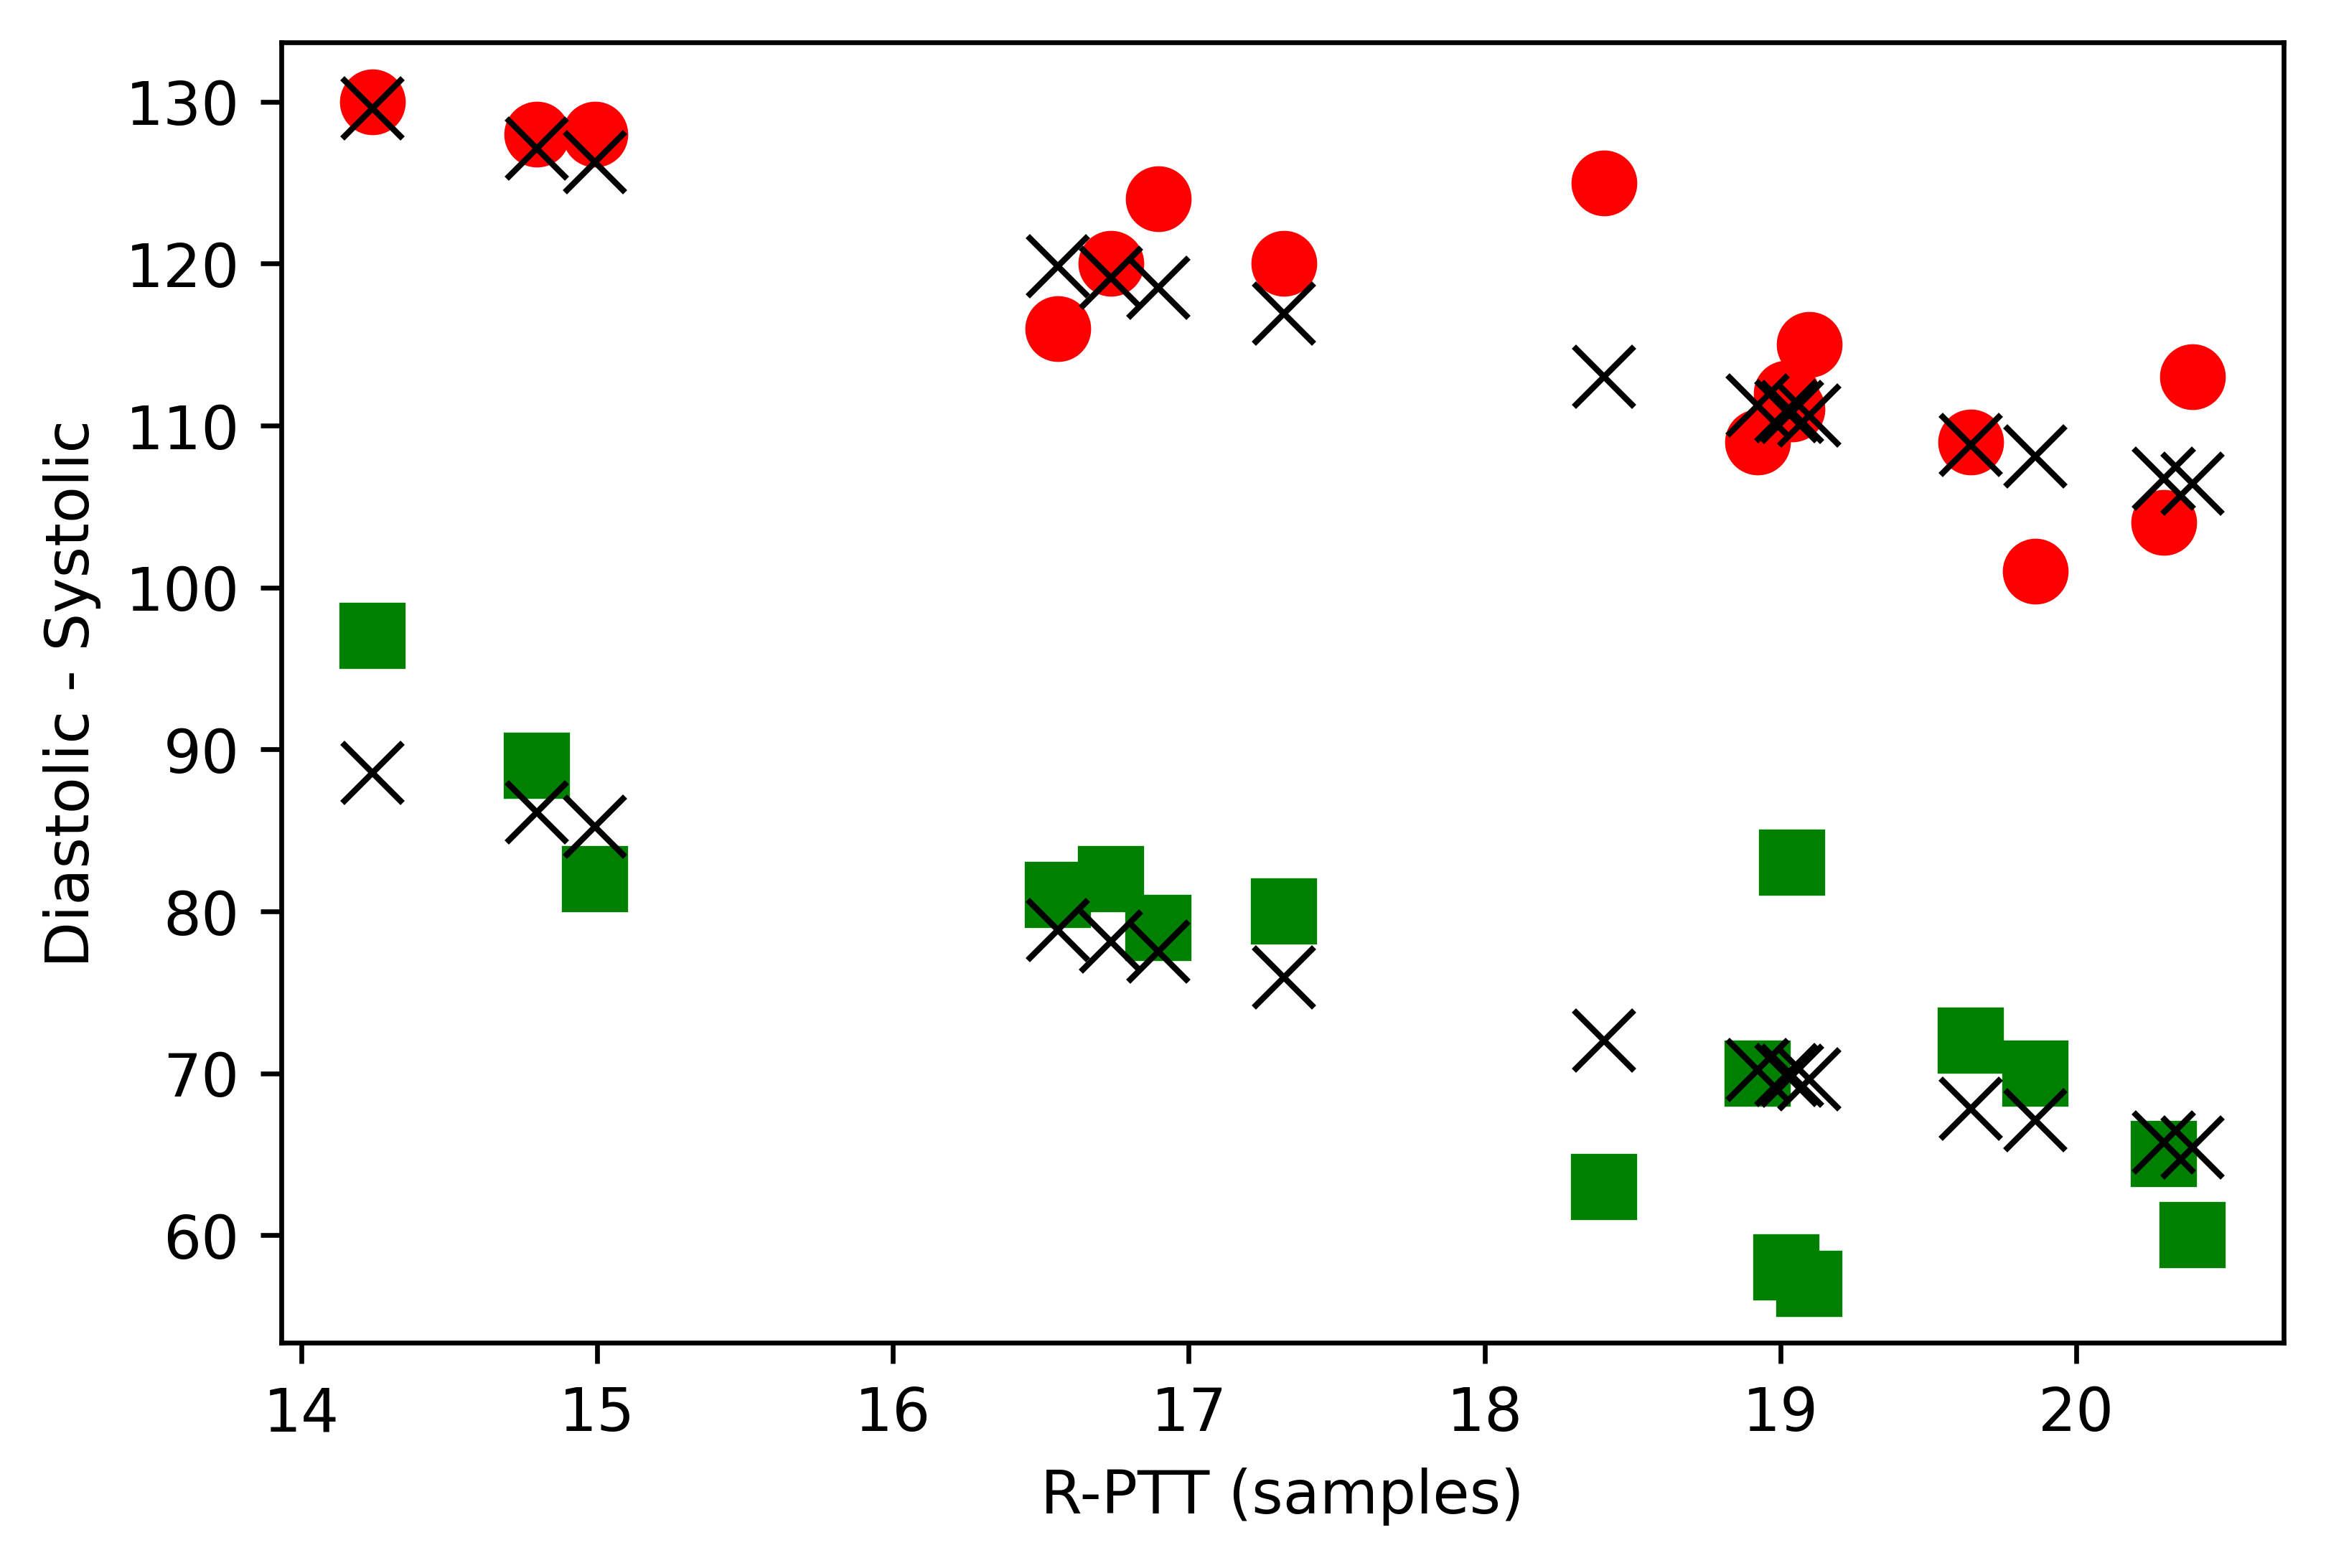

In [ ]:
# In[22]:
%matplotlib inline
from matplotlib import pyplot as plt
t_p = model(t_u, *params)
dbpt_p = SBPmodel(t_u, *params)
fig = plt.figure(dpi=600)
plt.xlabel("R-PTT (samples)")
plt.ylabel("Diastolic - Systolic")



plt.plot(t_u.numpy(), t_c.numpy(), 'sg',markersize=10)
plt.plot(t_u.numpy(), t_s.numpy(), 'or',markersize=10)
plt.plot(t_u.numpy(), t_p.detach().numpy(),'xk',markersize=10)
plt.plot(t_u.numpy(), dbpt_p.detach().numpy(),'xk',markersize=10)

In [ ]:
sbp_pre = SBPmodel(t_u,*params)

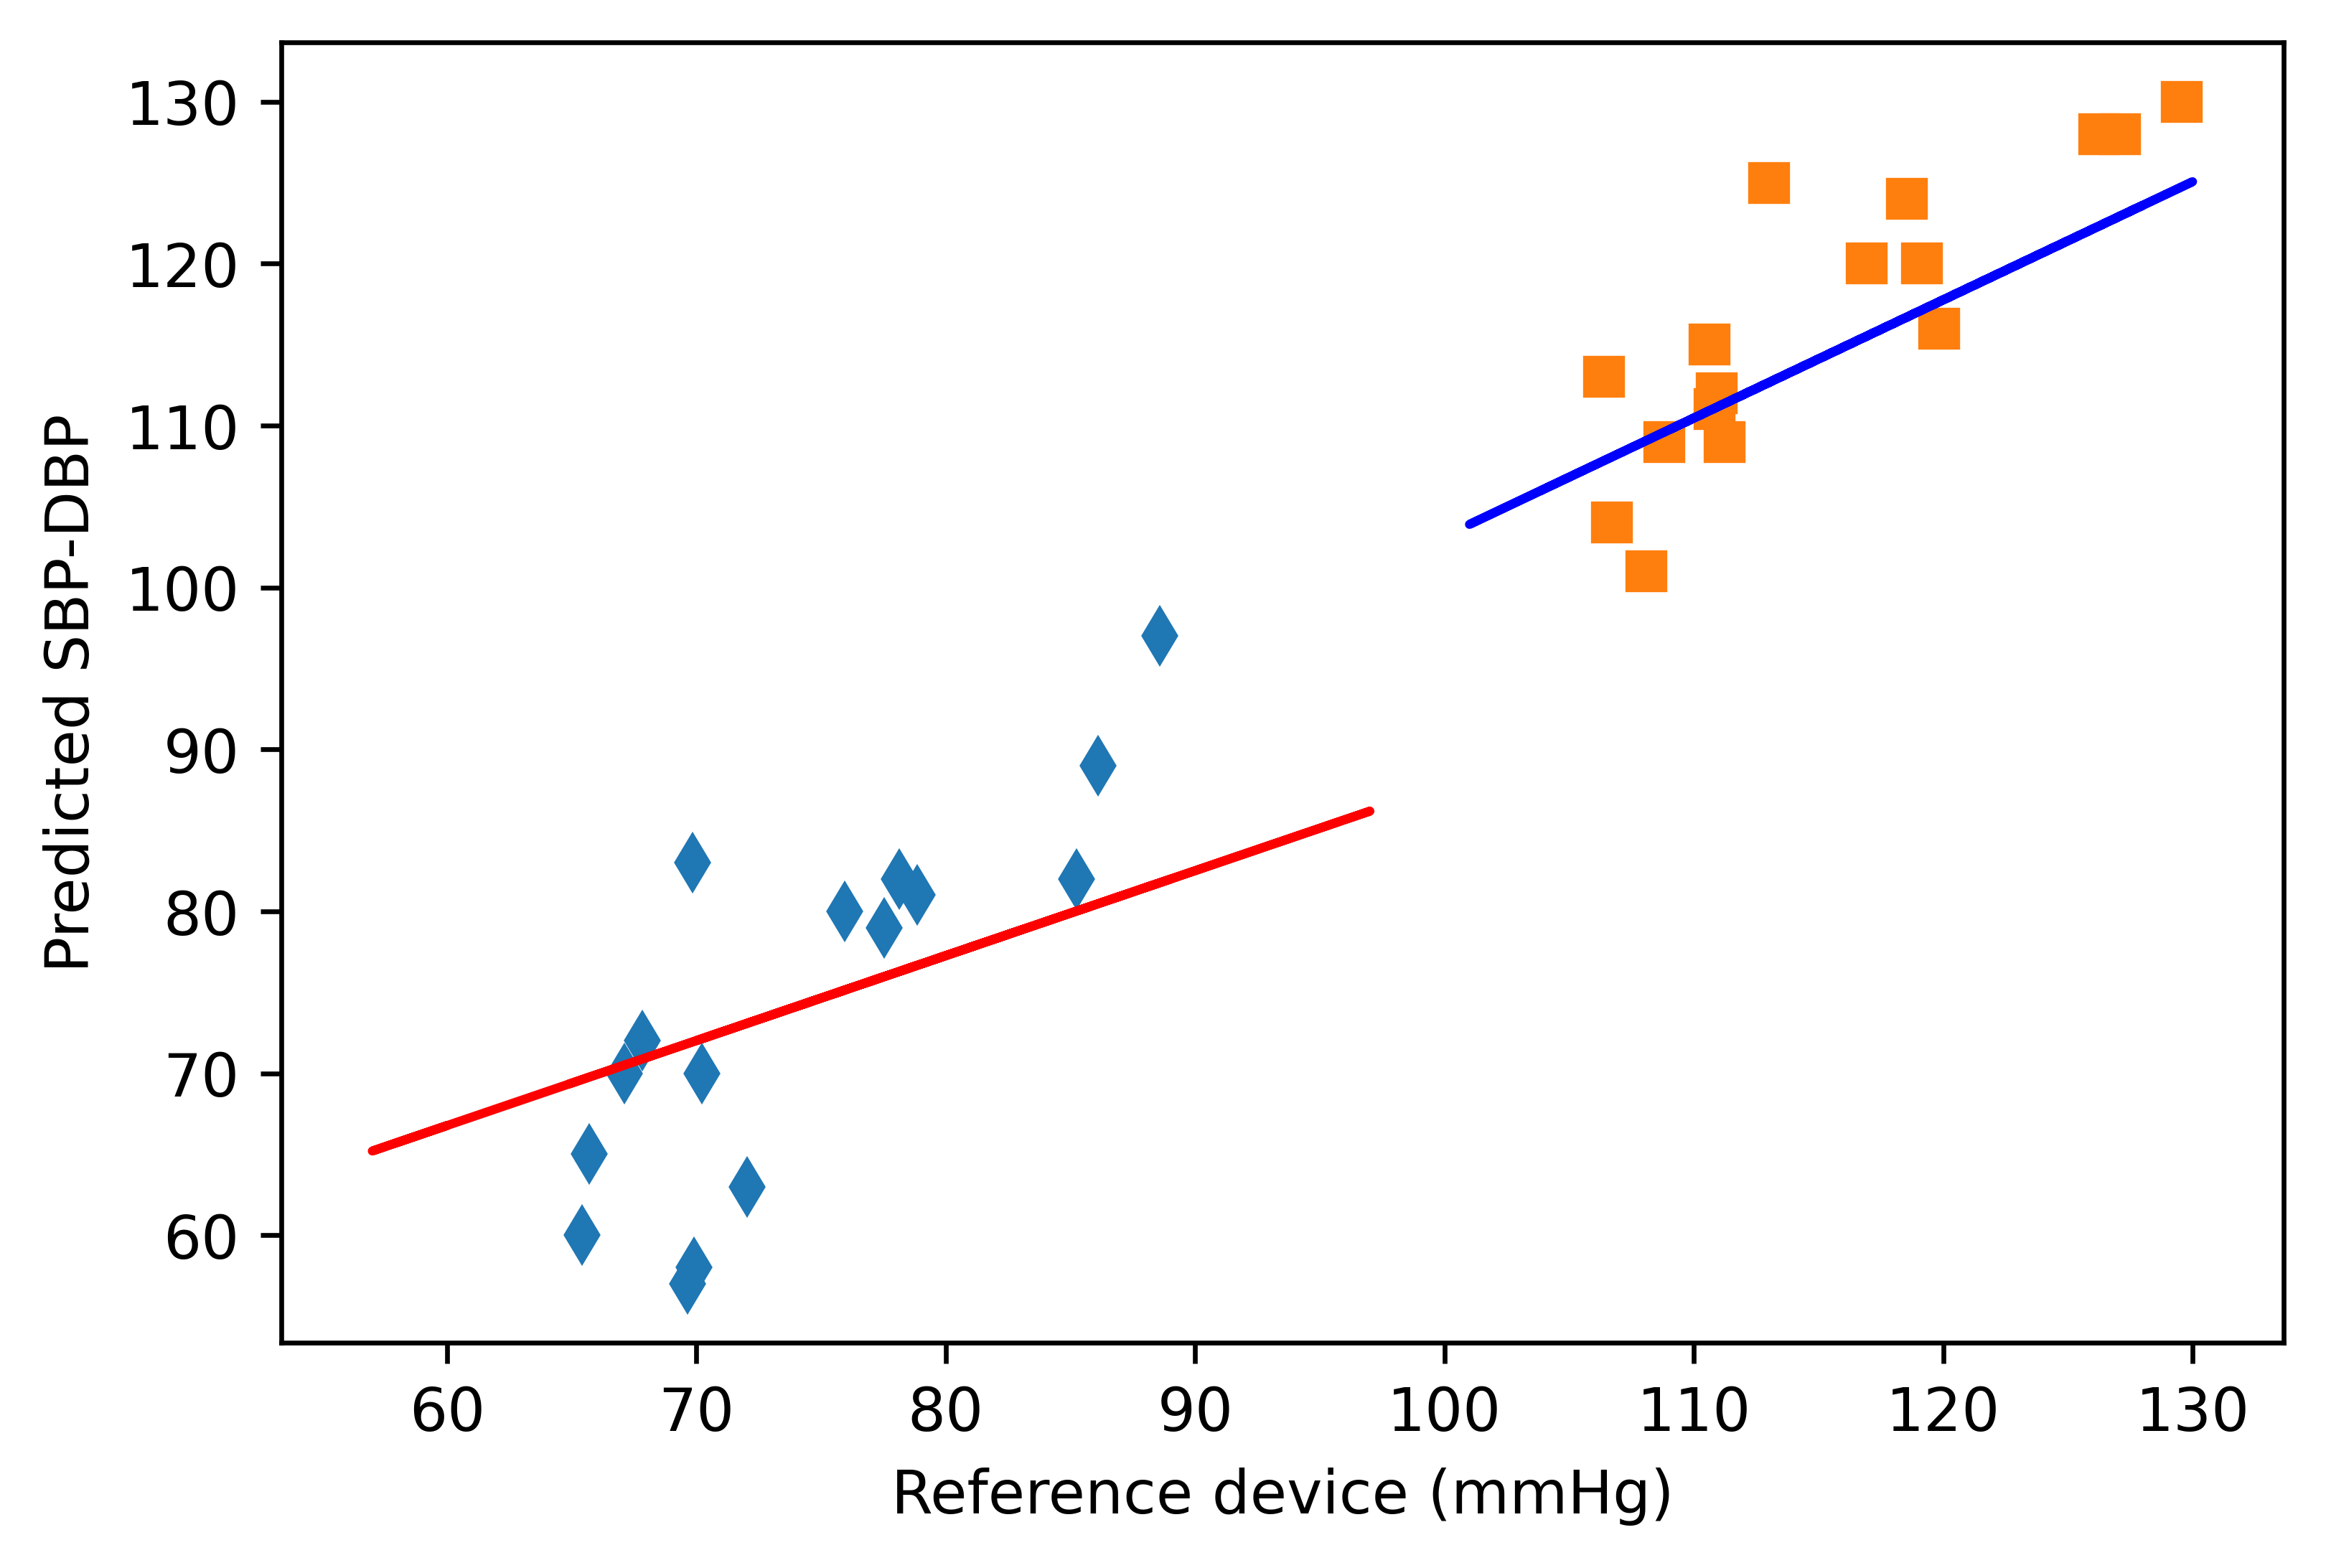

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
from sklearn.linear_model import LinearRegression
#from matplotlib import pyplot as plt

t_p = model(t_u, *params)
sbpt_p = SBPmodel(t_u, *params)

fig = plt.figure(dpi=600)
plt.xlabel("Reference device (mmHg)")
plt.ylabel("Predicted SBP-DBP")

X = t_c.numpy().reshape(-1,1)
Y = t_p.numpy().reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)

X1 = t_s.numpy().reshape(-1,1)
Y1 = sbpt_p.numpy().reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(X1, Y1)  # perform linear regression
Y1_pred = linear_regressor.predict(X1)

#plt.scatter(X, Y)
plt.plot(t_p.detach().numpy(), t_c.numpy(),'d')
plt.plot(sbpt_p.detach().numpy(), t_s.numpy(),'s')
plt.plot(X, Y_pred, color='red')
plt.plot(X1, Y1_pred, color='blue')
#plt.show()




#plt.plot(t_p.numpy(), dbpt_p.detach().numpy(),'x')
#plt.plot(t_u.numpy(), t_c.numpy(), 'o')
#plt.plot(t_u.numpy(), t_s.numpy(), 's')

In [ ]:
linear_regressor.fit(X, Y)
linear_regressor.score(X,Y)


0.6713688350473757

In [ ]:
linear_regressor.fit(X1, Y1)
linear_regressor.score(X1,Y1)

0.7434602371170299

In [ ]:
t_p.detach().numpy()

array([65.706696, 86.09748 , 67.81979 , 85.2485  , 70.22567 , 88.56847 ,
       67.10121 , 69.83478 , 78.838875, 78.145195, 75.93251 , 77.52757 ,
       72.01982 , 69.635155, 65.39909 , 69.8992  ], dtype=float32)

In [ ]:
model(18.235,*params)

tensor(72.6150)

## Blan Altman

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
colors = sns.color_palette("husl", 8)
colors = sns.color_palette("tab10")

#This function takes in the reference values and the prediction values as lists and returns a list with each index corresponding to the total number
#of points within that zone (0=A, 1=B, 2=C, 3=D, 4=E) and the plot
def blan_altman_plot(ref_values, pred_values, title_string, unit_string= '(mg/dl)'):

    #Checking to see if the lengths of the reference and prediction arrays are the same
    assert (len(ref_values) == len(pred_values)), "Unequal number of values (reference : {}) (prediction : {}).".format(len(ref_values), len(pred_values))

    #Checks to see if the values are within the normal physiological range, otherwise it gives a warning
    if max(ref_values) > 400 or max(pred_values) > 400:
        print("Input Warning: the maximum reference value {} or the maximum prediction value {} exceeds the normal physiological range of glucose (<400 mg/dl).".format(max(ref_values), max(pred_values)))
    if min(ref_values) < 0 or min(pred_values) < 0:
        print("Input Warning: the minimum reference value {} or the minimum prediction value {} is less than 0 mg/dl.".format(min(ref_values),  min(pred_values)))

    
    #Clear plot
    plt.clf()

    #Set up plot
    dif_values = pred_values - ref_values
    X= max(abs(min(ref_values)-0.5),abs(max(ref_values)+0.5))
    ampX = 50*(X//50 + 1)
    #xmin, xmax = min(ref_values)-0.5, max(ref_values)+0.5
    xmin, xmax = ampX-100, ampX+50
    
    Y= max(abs(min(dif_values)-1),abs(max(dif_values)+1))
    ampY = 5*(Y//5 + 2) #if (X%5!=0) else 5*(X//5) 
    ymin, ymax = -ampY, ampY
    # plot SD +/-1.96 SD and mean
    dif = pd.DataFrame(pred_values - ref_values)
    stat = dif.describe(percentiles = [0.05,0.5,0.95])[1:7].values.tolist()
    stat = [ item for x in stat for item in x ]  # flat the list [0.05, 0.5 and 0.95]

    plt.scatter(ref_values, dif_values, marker='o', color= colors[3], s=50)
    plt.title(title_string + " Bland-Altman Chart", color = 'black', fontsize = 25)
    plt.xlabel("Reference Concentration " + unit_string, fontsize = 25)
    plt.ylabel("The differnece value "+ unit_string, fontsize = 25)
    
    
    if ymax <20:
      yticks = np.arange(ymin, ymax + 0.5, 5)
    else:
      yticks = np.arange(ymin, ymax + 0.5, 10)
    
    scale = len(yticks)
    plt.yticks(yticks, fontsize = 25)
    plt.tick_params(axis ='both', which ='both', length = 5)  # set tick marks
    xticks = np.arange(xmin, xmax + 0.5, 100//scale)
    plt.xticks(xticks, fontsize = 25)
    #plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],fontsize = 25)
    #plt.yticks([-20, -15, -10, -5, 0, 5, 10, 15, 20],fontsize = 25)
    #plt.grid()
    plt.gca().set_facecolor('white')

    #Set axes lengths
    plt.gca().set_xlim([xmin, xmax])
    plt.gca().set_ylim([ymin, ymax])
    plt.gca().set_aspect((xmax-xmin)/(ymax - ymin))
    plt.xticks()
    
    plt.grid(axis='both', linestyle=':', color='0.15')
    plt.plot([xmax, xmax], [ymin, ymax], '-', c='black')
    plt.plot([xmin, xmin], [ymin, ymax], '-', c='black')
    #plt.plot([xmin, xmax], [0, 0], ':', c='black')            # y_axis
    plt.plot([xmin, xmax], [ymin, ymin], '-', c='black')            # x_axis
    plt.plot([xmin, xmax], [ymax, ymax], '-', c='black')            # x_axis
    #plot +/-1.96 SD and mean
    plt.plot([xmin, xmax], [stat[3], stat[3]], '--', c='red')            # x_axis 
    plt.plot([xmin, xmax], [stat[5], stat[5]], '--', c='red')            # x_axis 
    plt.plot([xmin, xmax], [stat[0], stat[0]], '-', c='blue')            # x_axis 
    labels = ['-1.96 SD', 'mean', '+1.96 SD' ]
    values = [f"{x:.2f}" for x in stat ]
    #plt.annotate(s = labels, xy = (180, stat[0]))
    plt.text(xmax - 40, stat[3]+ 0.2*scale, labels[0], fontsize=30, color =colors[3])
    plt.text(xmax - 25, stat[3]- 0.4*scale, values[3], fontsize=30, color =colors[3])
    plt.text(xmax - 27, stat[0]+ 0.2*scale, labels[1], fontsize=30, color ='blue')
    plt.text(xmax - 25, stat[0]- 0.4*scale, values[0], fontsize=30, color ='blue')
    plt.text(xmax - 41, stat[5]+ 0.2*scale, labels[2], fontsize=30, color =colors[3])
    plt.text(xmax - 25, stat[5]- 0.4*scale, values[5], fontsize=30, color =colors[3])
    
    
    #Statistics from the data
    zone = [0] * 5
    for i in range(len(dif_values)):
        if (abs(dif_values[i]) <= 5):
            zone[0] += 1    #Zone A

        elif (abs(dif_values[i]) <= 10):
            zone[1] += 1    #Zone B

        elif (abs(dif_values[i]) <=15):
            zone[2] += 1    #Zone C
        elif (abs(dif_values[i]) <= 20):
            zone[3] += 1    #Zone D
        else:
            zone[4] += 1    #Zone E

    return plt, zone

(<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>,
 [13, 3, 0, 0, 0])

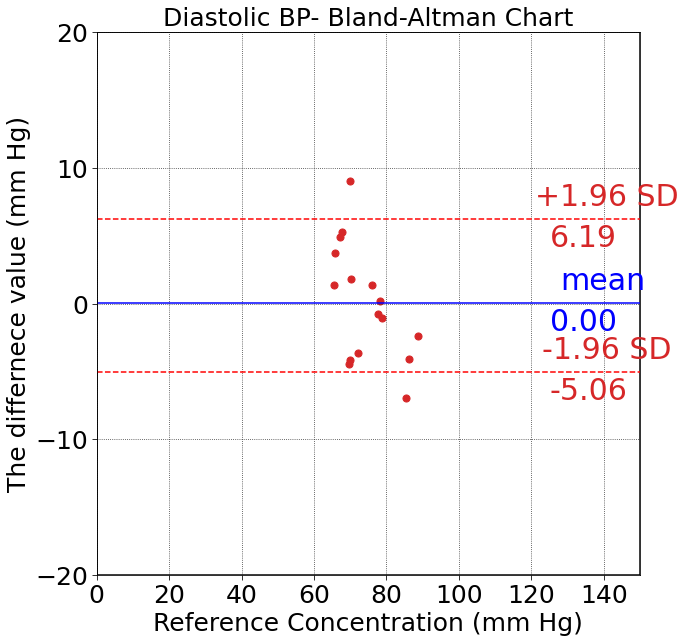

In [ ]:
plt.figure(1, figsize=(10,10))
#Y_pred = model.predict(X_test)
blan_altman_plot(Y, Y_pred, 'Diastolic BP-', '(mm Hg)')

(<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>,
 [14, 2, 0, 0, 0])

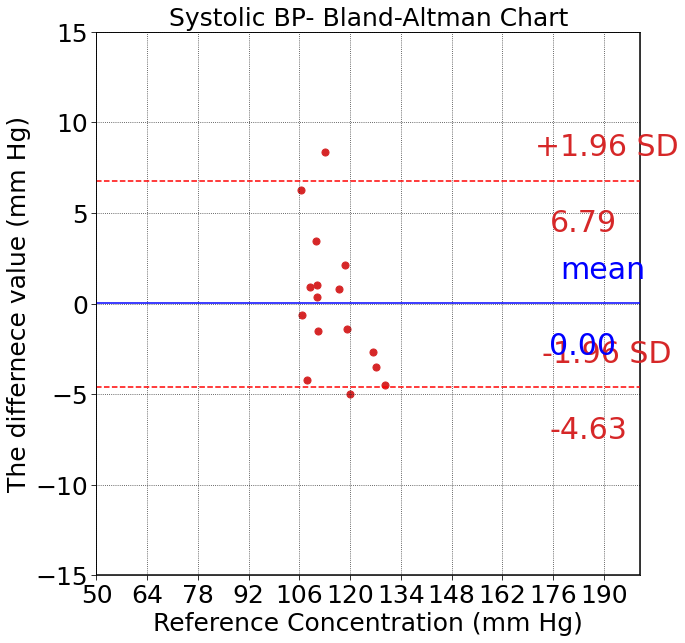

In [ ]:
plt.figure(1, figsize=(10,10))
#Y_pred = model.predict(X_test)
blan_altman_plot(Y1, Y1_pred, 'Systolic BP-', '(mm Hg)')

(<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>,
 [27, 5, 0, 0, 0])

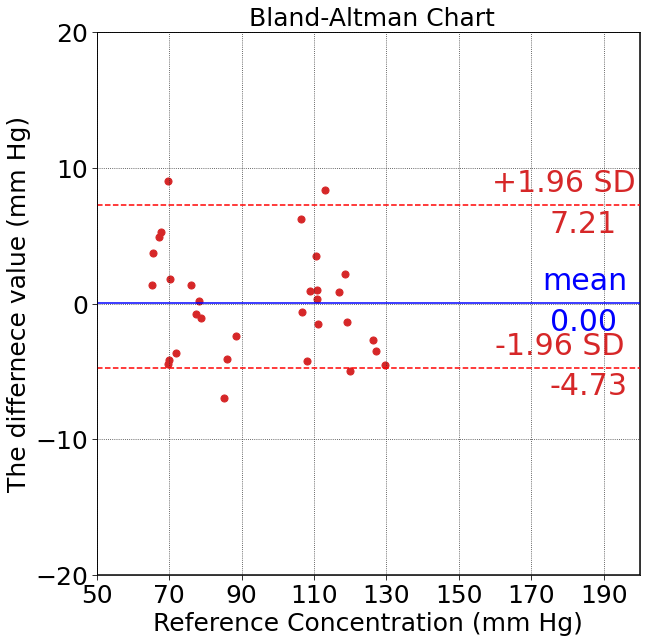

In [ ]:
Y2 = np.append(Y, Y1)
Y2_pred = np.append(Y_pred, Y1_pred)
plt.figure(1, figsize=(10,10))
#Y_pred = model.predict(X_test)
blan_altman_plot(Y2, Y2_pred, '', '(mm Hg)')

In [ ]:
Y2

array([ 65.706696,  86.09748 ,  67.81979 ,  85.2485  ,  70.22567 ,
        88.56847 ,  67.10121 ,  69.83478 ,  78.838875,  78.145195,
        75.93251 ,  77.52757 ,  72.01982 ,  69.635155,  65.39909 ,
        69.8992  , 106.70886 , 127.101555, 108.822105, 126.252464,
       111.228165, 129.57286 , 108.10348 , 110.83724 , 119.842125,
       119.14838 , 116.935486, 118.53069 , 113.02245 , 110.6376  ,
       106.40124 , 110.901665], dtype=float32)